<a href="https://colab.research.google.com/github/EOKvashnin/EOKvashnin_public_repository/blob/main/predict_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Импортируем необходимые библиотеки

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib as Path

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import files

# Подключение библиотеки для работы с файлами на Google Диске
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Создание и подготовка тренировочного и валидационного набора данных для последующего обучения модели

In [ ]:
from pathlib import Path

# Указываем путь к директории с  тренировочными изображениями
dataset_dir = Path('/content/drive/MyDrive/colab_notebooks/defect_detection/test_image/train')

# Подсчитываем количество изображений с расширением .bmp
image_count = len(list(dataset_dir.glob('*/*.bmp')))

print(f'Всего изображений: {image_count}')



Всего изображений: 1656


In [ ]:
# Параметры
dataset_dir = '/content/drive/MyDrive/colab_notebooks/defect_detection/test_image/train'  # Путь к директории с изображениями
batch_size = 32                                                                   # Размер батча для загрузки данных
image_width = 200                                                                 # Ширина изображений
image_height = 200                                                                # Высота изображений

# Загружаем тренировочный набор данных
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,                                                                  # Директория с изображениями
    validation_split=0.2,                                                         # Доля данных, отведенная для валидации
    subset="training",                                                            # Указываем, что это тренировочный набор
    seed=123,                                                                     # Сид для воспроизводимости разбиения на тренировочный и валидационный наборы
    image_size=(image_height, image_width),                                       # Размер изображений, к которому они будут приведены
    batch_size=batch_size                                                         # Размер батча
)

# Загружаем валидационный набор данных
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,                                                                  # Директория с изображениями
    validation_split=0.2,                                                         # Доля данных, отведенная для валидации
    subset="validation",                                                          # Указываем, что это валидационный набор
    seed=123,                                                                     # Сид для воспроизводимости разбиения на тренировочный и валидационный наборы
    image_size=(image_height, image_width),                                       # Размер изображений, к которому они будут приведены
    batch_size=batch_size                                                         # Размер батча
)

# Получаем названия классов
class_names = train_ds.class_names                                                # Извлекаем названия классов из тренировочного набора данных
print(f'Class_names: {class_names}')                                              # Выводим названия классов

# Кэширование
AUTOTUNE = tf.data.AUTOTUNE                                                       # Автоматическая настройка для оптимизации производительности
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)                        # позволяет кэшировать данные в памяти, чтобы ускорить последующие загрузки.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1656 files belonging to 6 classes.
Using 1325 files for training.
Found 1656 files belonging to 6 classes.
Using 331 files for validation.
Class_names: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


### 3. Создание модели

42/42 - 17s - 401ms/step - accuracy: 0.9449 - loss: 0.1553
Restored model, accuracy: 94.49%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
На изображении скорее всего Scratches (99.96% вероятность)


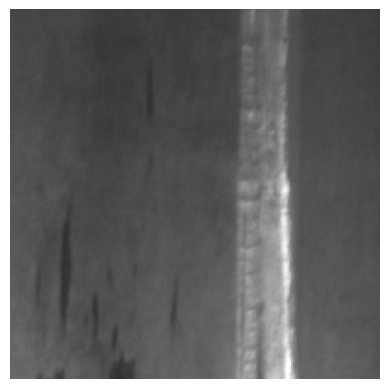

In [ ]:
num_classes = len(class_names)                                                    # Определяем количество классов на основе названий классов
model = Sequential([
    layers.Input(shape=(image_height, image_width, 3)),                           # Определяем форму входных данных (высота, ширина, количество каналов)
    layers.Rescaling(1./255),                                                     # Нормализуем пиксели изображений (приводим значения к диапазону [0, 1])

     # Выполняем аугментацию датасета для увеличения разнообразия данных
    layers.RandomFlip('horizontal'),                                              # Случайное горизонтальное отражение изображений
    layers.RandomRotation(0.1),                                                   # Случайное вращение изображений на 10%
    layers.RandomZoom(0.1),                                                       # Случайное увеличение изображений на 10%
    layers.RandomContrast(0.2),                                                   # Случайная контрастность изображений

    # Свёрточные слои для извлечения признаков
    layers.Conv2D(16, 3, padding='same', activation='relu'),                      # Свёрточный слой с 16 фильтрами размером 3x3
    layers.MaxPooling2D(),                                                        # Слой подвыборки для уменьшения размерности

    layers.Conv2D(32, 3, padding='same', activation='relu'),                      # Свёрточный слой с 32 фильтрами
    layers.MaxPooling2D(),                                                        # Слой подвыборки

    layers.Conv2D(64, 3, padding='same', activation='relu'),                      # Свёрточный слой с 64 фильтрами
    layers.MaxPooling2D(),                                                        # Слой подвыборки

    # Регуляризация для уменьшения переобучения
    layers.Dropout(0.2),                                                          # Слой Dropout, отключающий 20% нейронов во время обучения

    layers.Flatten(),                                                             # Преобразуем многомерный тензор в одномерный
    layers.Dense(128, activation='relu'),                                         # Полносвязный слой с 128 нейронами и активацией ReLU
    layers.Dense(num_classes)                                                     # Выходной слой с количеством нейронов, равным количеству классов
])

# Кампиляция модели
model.compile(
    optimizer='adam',                                                             # Используем оптимизатор Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),         # Функция потерь для многоклассовой классификации
    metrics=['accuracy'])                                                         # Метрика для оценки точности

# Загрузка весов в модель (Веса, созданные в процессе обучения на шаге 4)
model.load_weights('/content/drive/MyDrive/colab_notebooks/defect_detection/metal_defects_model.weights.h5')

# Оцениваем модель на тренировочном наборе данных
loss, acc = model.evaluate(train_ds, verbose=2)                                   # Получаем значение потерь и точности
print(f"Restored model, accuracy: {100 * acc:.2f}%")                              # Выводим точность модели

# Загрузка изображения для распознавания

img = tf.keras.utils.load_img('/content/drive/MyDrive/colab_notebooks/defect_detection/Sc_109.bmp', target_size=(image_height, image_width)) # Загружаем тестовое изображение и изменяем его размер
img_array = tf.keras.utils.img_to_array(img)                                      # Преобразуем изображение в массив
img_array = tf.expand_dims(img_array, 0)                                          # Добавляем размерность для батча (требуется для предсказания)

# Делаем предсказание

prediction = model.predict(img_array)                                             # Получаем предсказание от модели
score = tf.nn.softmax(prediction[0])                                              # Применяем softmax для получения вероятностей классов

# Вывод результата инференса

print('На изображении скорее всего {} ({:.2f}% вероятность)'.format(
    class_names[np.argmax(score)],                                                # Класс с максимальной вероятностью
    100 * (np.max(score))))                                                       # Вероятность этого класса

# Вывод изображения

plt.imshow(img)
plt.axis('off')  # Отключаем оси
plt.show()


# Вывод структуры модели
#model.summary()

# `Обучение модели`

Вывод основных метрик модели : Accuracy(Точность) & Loss(Потери)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 311s 7s/step - accuracy: 0.2163 - loss: 2.1219 - val_accuracy: 0.2477 - val_loss: 1.6468
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3770 - loss: 1.4656 - val_accuracy: 0.5045 - val_loss: 1.4709
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5033 - loss: 1.3761 - val_accuracy: 0.5861 - val_loss: 1.1326
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.5812 - loss: 1.1139 - val_accuracy: 0.5076 - val_loss: 1.4848
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.6954 - loss: 0.9287 - val_accuracy: 0.7613 - val_loss: 0.7597
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7289 - loss: 0.8400 - val_accuracy: 0.7069 - val_loss: 0.7751
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7792 - loss: 0.6774 - val_accuracy: 0.8550 - val_loss: 0.4703
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8089 - loss: 0.5705 - val_accuracy: 0.8610 - val_loss

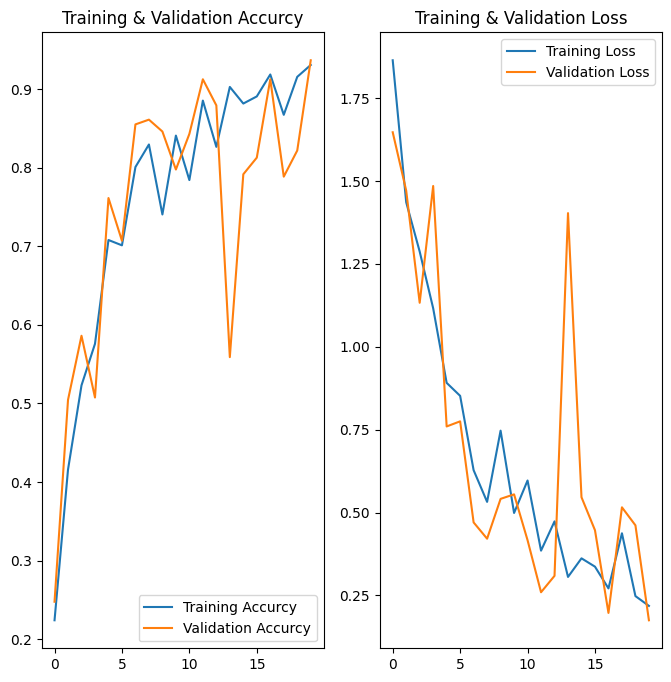

Модель сохранена


In [ ]:
 # Обучение модели

epochs = 20                                                                       # Устанавливаем количество эпох тренировки (количество полных проходов по тренировочному набору данных)
history = model.fit(
     train_ds,                                                                    # Тренировочный набор данных
    validation_data=val_ds,                                                       # Валидационный набор данных для оценки модели после каждой эпохи
    epochs=epochs)                                                                # Количество эпох, заданное ранее

# Визуализация результатов тренировки и валидации
acc = history.history['accuracy']                                                 # Извлекаем значения точности на тренировочном наборе
val_acc = history.history['val_accuracy']                                         # Извлекаем значения точности на валидационном наборе

loss = history.history['loss']                                                    # Извлекаем значения потерь на тренировочном наборе
val_loss = history.history['val_loss']                                            # Извлекаем значения потерь на валидационном наборе

epochs_range = range(epochs)                                                      # Создаем диапазон для оси X, который будет использоваться в графиках

plt.figure(figsize=(8,8))                                                         # Выставляем параметры графиков для отображения точности тренировочного и валид. набора и потерь тернир. и валид. набора
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accurcy')
plt.plot(epochs_range, val_acc, label='Validation Accurcy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accurcy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()

# Сохранение весов модели в файл
model.save_weights('/content/drive/MyDrive/colab_notebooks/defect_detection/metal_defects_model.weights.h5')
print ('Модель сохранена')


## **Сохранение файла модели (Скачать себе на компьютер)**

In [ ]:
model_file_name = '/content/drive/MyDrive/colab_notebooks/defect_detection/metal_defects_model.keras'

# Сохранение модели
model.save(model_file_name)

# Загрузка модели
files.download(model_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>